In [1]:
# ! pip install tabula-py
# !java -version
#### ###

# Kör denna py först

In [2]:
import tabula
from IPython.display import display
import pandas as pd 
import re
import numpy as np
import pickle
# import time

from selenium import webdriver 
from selenium.webdriver.common.by import By 
# from selenium.webdriver.support.ui import WebDriverWait 
# from selenium.webdriver.support import expected_conditions as EC 
# from selenium.common.exceptions import TimeoutException
driver=None

# Scrape av PDF

In [3]:
def get_pdf_files(driver):
    
    p = driver.find_element(By.CSS_SELECTOR, 'div.link-list-block a[href*=comirnaty]')
    url_pfizer = p.get_attribute('href')
    
    a = driver.find_element(By.CSS_SELECTOR, 'div.link-list-block a[href*=vaxzevria]')
    url_astra = a.get_attribute('href')

    m = driver.find_element(By.CSS_SELECTOR, 'div.link-list-block a[href*=spikevax]')
    url_moderna = m.get_attribute('href')

    pdf_astra   = tabula.read_pdf(url_astra  , pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 
    pdf_pfizer  = tabula.read_pdf(url_pfizer , pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 
    pdf_moderna = tabula.read_pdf(url_moderna, pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 
    return pdf_astra, pdf_pfizer, pdf_moderna   



In [4]:
def find_ix_in_pdf(pdf, word):
    # print(range(0,len(pdf)))
    for i in range(0, len(pdf)):
        # print(i)
        tab = list(pdf[i].columns)
        tab = [x.replace('\r', ' ') for x in tab]
        tab_str = ''.join(tab)
        if word in tab_str:
            print('Found word', word, 'in pdf', i)
            return pdf[i], i

    return 'Error', -1000

def antal_döda(pdf_astra,pdf_pfizer,pdf_moderna):
       print('pdf_astra', end=': ')
       _, ixa = find_ix_in_pdf(pdf_astra, 'Dödsfall')
       print('pdf_pfizer', end=': ')
       _, ixp = find_ix_in_pdf(pdf_pfizer, 'Dödsfall')
       print('pdf_moderna', end=': ')
       _, ixm = find_ix_in_pdf(pdf_moderna, 'Dödsfall')
          
       a = ['Astra'] + pdf_astra[ixa].loc[:,'Totalt'].astype(int).to_list()
       try:
              m = ['Moderna'] + pdf_moderna[ixm].loc[:,'Totalt'].str.replace(',','').astype(int).to_list()
       except:
              m = ['Moderna'] + pdf_moderna[ixm].loc[:,'Totalt'].astype(int).to_list()       
              
       pdf_pfizer[ixp].columns = ['Dödsfall', '10-19', '20-29', '30-39', '40-49',
              '50-59', '60-69', '70-79', '80-89', '90+',
              'okänt', 'Totalt']
       p = ['Pfizer'] + pdf_pfizer[ixp].loc[:,'Totalt'].astype(int).to_list()
       p = p[:-2]+[p[-1]] # ta bort okänt (kön)

       df =pd.DataFrame([p,m,a], columns=['Antal_döda','Kvinnor','Män','Totalt'])
       df.loc[-1]=['Totaler']+df[['Kvinnor','Män','Totalt']].sum().to_list()
       
       df = df.set_index('Antal_döda')
        
       return df
# antal_döda(pdf_astra,pdf_pfizer,pdf_moderna)


In [5]:

def antal_allvarliga(pdf_astra,pdf_pfizer,pdf_moderna):
       print('pdf_astra', end=': ')
       _,ixa = find_ix_in_pdf(pdf_astra, 'allvarlig')
       print('pdf_pfizer', end=': ')
       _,ixp = find_ix_in_pdf(pdf_pfizer, 'allvarlig')
       print('pdf_moderna', end=': ')
       _,ixm = find_ix_in_pdf(pdf_moderna, 'allvarlig')
       kolumner = ['Ej allvarliga', 'Allvarliga']
       astra = pdf_astra[ixa].drop('Totalt',axis=1).copy()
       
       astra.columns=['Astra'] + kolumner
       astra['Ej allvarliga'] = astra['Ej allvarliga'].str.replace(',','').astype(int)
       astra['Allvarliga'] = astra['Allvarliga'].str.replace(',','').astype(int)
       astra['Totalt'] = astra['Ej allvarliga'] + astra.Allvarliga
       
       moderna = pdf_moderna[ixm].drop('Totalt',axis=1).copy()
       # print(moderna)
       moderna.columns=['Moderna'] + kolumner
       moderna['Allvarliga'] = moderna['Allvarliga'].str.replace(',','').astype(int)
       moderna['Ej allvarliga'] = moderna['Ej allvarliga'].str.replace(',', '').astype(int)
       moderna['Totalt'] = moderna['Ej allvarliga'] + moderna.Allvarliga
       # print(moderna)
       pfizer = pdf_pfizer[ixp].drop('Totalt',axis=1).copy()
       pfizer.columns=['Pfizer'] + kolumner
       pfizer['Ej allvarliga'] = pfizer['Ej allvarliga'].str.replace(',','').astype(int)
       pfizer['Allvarliga']    = pfizer['Allvarliga'].str.replace(',','').astype(int)
       pfizer['Totalt']       = pfizer['Ej allvarliga'] + pfizer.Allvarliga
      
       # moderna['Totalt']+astra['Totalt']+pfizer['Totalt']
       # print('SVAR',moderna)
       return (astra,pfizer,moderna)

# antal_allvarliga(pdf_astra,pdf_pfizer,pdf_moderna)


In [6]:
# pdf_astra[2].columns

# Scrape av sidan

In [7]:
# create driver and start url
url='https://www.lakemedelsverket.se/sv/coronavirus/coronavaccin/inrapporterade-misstankta-biverkningar---coronavacciner'
driver = webdriver.Chrome(executable_path='C:\\Users\peter\\Documents\\MyProjects\\gecko\\chromedriver.exe')
driver.get(url)              # öppna startlista
driver.implicitly_wait(5)     # seconds

C:\Users\peter\AppData\Local\Temp\ipykernel_14944\659082753.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path='C:\\Users\peter\\Documents\\MyProjects\\gecko\\chromedriver.exe')


In [8]:
datconv={'Januari':'January', 'Februari':'February', 'Mars':'March', 'April':'April', 'Maj':'May', 'Juni':'June', 'Juli':'July', 'Augusti':'August', 'September':'September', 'Oktober':'October', 'November':'November', 'December':'December',
         'januari':'january', 'februari':'february', 'mars':'march', 'april':'april', 'maj':'may', 'juni':'june', 'juli':'july', 'augusti':'august', 'september':'september', 'oktober':'october', 'november':'november', 'december':'december'}
def get_date_of_report(driver):
    datum = driver.find_element(By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/ul/li[2]/span[2]').text
    # replace month in datum    
    for k,v in datconv.items():
        datum = datum.replace(k,v)
    return pd.to_datetime(datum).strftime('%Y-%m-%d')



# d=get_date_of_report(driver)
# d
# # week number of d
# week = pd.to_datetime(d).week
# print(d)
# print(week)

In [9]:

def get_antal_okända(driver):
    # löpande_text = driver.find_elements_by_xpath('//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/p[5]')[0].text
    #löpande_text = driver.find_elements(By.XPATH,'//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/p[6]')[0].text
    löpande_text = driver.find_elements(By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div')[0].text
    
    # print(löpande_text)
    sök_på = ' har det även kommit in '
    startix = löpande_text.find(sök_på) + len(sök_på)  # här startar det numeriska värdet
    numlen= löpande_text[startix:].find(' ')
    
    antal_okända = löpande_text[startix:startix+numlen]
    print('antal okända',antal_okända)
    return int(antal_okända)
antal_okänd_spruta = get_antal_okända(driver)


antal okända 349


In [10]:
driver.find_elements(
    By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[8]')[0].text

# '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/div[3]/p[2]/span'
# '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/div[3]/p[2]/span'


'Antal inkomna rapporter: 56 440 (varav 176 är Comirnaty Omicron)'

In [11]:
# Moderna
astra_inkomna = driver.find_elements(By.XPATH,
                                     '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[16]')[0].text
astra_inkomna = astra_inkomna.replace(' ', '')
# find the first number in the string
astra_inkomna = int(re.findall(r'\d+', astra_inkomna)[0].replace(' ', ''))
print('astra inkomna', astra_inkomna)


astra inkomna 24743


In [12]:
#  tabellen med antal doser och inkommna rapporter
def get_inkomna_rapporter(driver):    
    # inkomna = driver.find_element_by_class_name('tinyMceTable')
    pfizer_inkomna = driver.find_elements(
        By.XPATH,'//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[8]')[0].text
    pfizer_inkomna = pfizer_inkomna.replace(' ','')
    # find the first number in the string
    pfizer_inkomna = int(re.findall(r'\d+', pfizer_inkomna)[0].replace(' ',''))
    print('pfizer inkomna',pfizer_inkomna)
    
    moderna_inkomna = driver.find_elements(By.XPATH, 
                                           '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[13]')[0].text
    moderna_inkomna = moderna_inkomna.replace(' ', '')
    # find the first number in the string
    moderna_inkomna = int(re.findall(r'\d+', moderna_inkomna)[0].replace(' ',''))
    print('moderna inkomna',moderna_inkomna)
    
    astra_inkomna = driver.find_elements(By.XPATH, 
                                         '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[16]')[0].text
    astra_inkomna = astra_inkomna.replace(' ', '')
    # find the first number in the string
    astra_inkomna = int(re.findall(r'\d+', astra_inkomna)[0].replace(' ', ''))
    print('astra inkomna',astra_inkomna)
    # elems = inkomna_pf.find_elements_by_tag_name('tr')
    
    # pfizer_inkomna = int(elems[1].find_elements_by_tag_name('td')[2].text.replace(' ',''))
    # moderna_inkomna = int(elems[2].find_elements_by_tag_name('td')[2].text.replace(' ',''))
    # astra_inkomna = int(elems[3].find_elements_by_tag_name('td')[2].text.replace(' ',''))
    
    return pfizer_inkomna, moderna_inkomna, astra_inkomna

summa_rapporter = sum(get_inkomna_rapporter(driver))+antal_okänd_spruta
with open('pickle/summa_rapporter.pkl','wb') as f:
    pickle.dump(summa_rapporter, f)
    
print('summa_rapporter:',summa_rapporter)  
print(f"\nOBS\nKOLLA ATT 349 == {antal_okänd_spruta} RAPPORTER AV OKÄND SPRUTA\nOBS\n")   
print('Dump antal okänd spruta =',antal_okänd_spruta)

with open('pickle/okänd_spruta.pkl','wb') as f:
    pickle.dump(antal_okänd_spruta, f)


pfizer inkomna 56440
moderna inkomna 23578
astra inkomna 24743
summa_rapporter: 105110

OBS
KOLLA ATT 349 == 349 RAPPORTER AV OKÄND SPRUTA
OBS

Dump antal okänd spruta = 349


In [13]:

# driver.find_elements(
#     By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/div[3]/p[9]')[0].text[19:]


In [14]:

def get_antal_doser(driver):
    #  tabellen med antal doser och inkommna rapporter
    # doser = driver.find_element_by_class_name('tinyMceTable')
    # elems = doser.find_elements_by_tag_name('tr')
    pfizer_doser = driver.find_elements(
        By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[7]')[0].text
    pfizer_doser = pfizer_doser.replace(' ', '')
    # find the first number in the string
    pfizer_doser = int(re.findall(r'\d+', pfizer_doser)[0].replace(' ', ''))
    print('pfizer_doser',pfizer_doser)
    
    moderna_doser = driver.find_elements(
        By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[12]')[0].text
    moderna_doser = moderna_doser.replace(' ', '')
    # find the first number in the string
    moderna_doser = int(re.findall(r'\d+', moderna_doser)[0].replace(' ', ''))
    print('moderna_doser',moderna_doser)
    
    astra_doser = driver.find_elements(
        By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[15]')[0].text
    astra_doser = astra_doser.replace(' ', '')
    # find the first number in the string
    astra_doser = int(re.findall(r'\d+', astra_doser)[0].replace(' ', ''))
    
    print('astra_doser',astra_doser)
    return pfizer_doser,moderna_doser,astra_doser

get_antal_doser(driver)


pfizer_doser 19896235
moderna_doser 4496008
astra_doser 1338215


(19896235, 4496008, 1338215)

# Get pdf-filer 
#### men först antal inkomna rapporter, antal doser, antal veckor

In [15]:
datum = get_date_of_report(driver)
week = pd.to_datetime(datum).week
antal_veckor = 52 + week

pfizer_inkomna, moderna_inkomna, astra_inkomna = get_inkomna_rapporter(driver)
summa_rapporter # inkluderar rapporter av okänd spruta

# print('antal rapporter',summa_rapporter, 'snitt per vecka',int(summa_rapporter/antal_veckor)) 
Antal_Rapporter = pd.DataFrame([[summa_rapporter,int(summa_rapporter/antal_veckor)]],columns=['inrapporterat','veckosnitt'])
display(Antal_Rapporter)

pfizer_doser,moderna_doser,astra_doser = get_antal_doser(driver)
antal_doser = pfizer_doser + moderna_doser + astra_doser
print('Antal doser. Pfizer,Moderna,Astra:',pfizer_doser,moderna_doser,astra_doser)
print('Antal inkomna rapporter i relation till antl doser. Pf,Mo,As',end=': ')
for p in [pfizer_inkomna/pfizer_doser,  moderna_inkomna/moderna_doser,  astra_inkomna/astra_doser]:
    print(round(p*100,2),end=' ')

# Antal_Rapporter.to_excel('Rapporterat.xlsx',index=False)
pdf_astra, pdf_pfizer, pdf_moderna = get_pdf_files(driver)

pfizer inkomna 56440
moderna inkomna 23578
astra inkomna 24743


,inrapporterat,veckosnitt
0,105110,1723


pfizer_doser 19896235
moderna_doser 4496008
astra_doser 1338215
Antal doser. Pfizer,Moderna,Astra: 19896235 4496008 1338215
Antal inkomna rapporter i relation till antl doser. Pf,Mo,As: 0.28 0.52 1.85 

In [16]:
display("ANTAL DÖDA")
Antal_Döda = antal_döda(pdf_astra,pdf_pfizer,pdf_moderna)
Antal_Döda['Veckosnitt'] = round(Antal_Döda.Totalt/antal_veckor,1)
display(Antal_Döda)
# Antal_Döda.to_excel('Antal_döda.xlsx')

lista=antal_allvarliga(pdf_astra,pdf_pfizer,pdf_moderna )
display("ANTAL HANDLAGDA")
Astra = pd.DataFrame(lista[0])
Pfizer = pd.DataFrame(lista[1])
Moderna = pd.DataFrame(lista[2])
display(Astra)
display (Pfizer)
display(Moderna)
# Astra.to_excel('Astra_handlagda.xlsx',index=False)
# Pfizer.to_excel('Pfizer_handlagda.xlsx',index=False)
# Moderna.to_excel('Moderna_handlagda.xlsx',index=False)

'ANTAL DÖDA'

pdf_astra: Found word Dödsfall in pdf 5
pdf_pfizer: Found word Dödsfall in pdf 5
pdf_moderna: Found word Dödsfall in pdf 5


,Kvinnor,Män,Totalt,Veckosnitt
Antal_döda,,,,
Pfizer,176,149,326,5.3
Moderna,23,28,51,0.8
Astra,20,30,50,0.8
Totaler,219,207,427,7.0


pdf_astra: Found word allvarlig in pdf 2
pdf_pfizer: Found word allvarlig in pdf 2
pdf_moderna: Found word allvarlig in pdf 2


'ANTAL HANDLAGDA'

,Astra,Ej allvarliga,Allvarliga,Totalt
0,Hälso och Sjukvård,5534,1052,6586
1,Konsument,16088,1380,17468
2,Antal rapporter,21622,2432,24054


,Pfizer,Ej allvarliga,Allvarliga,Totalt
0,Hälso och Sjukvård,5774,3145,8919
1,Konsument,38238,4819,43057
2,Antal rapporter,44012,7964,51976


,Moderna,Ej allvarliga,Allvarliga,Totalt
0,Hälso och Sjukvård,1997,816,2813
1,Konsument,17247,1459,18706
2,Antal rapporter,19244,2275,21519


In [17]:
# pdf_astra

In [18]:
display('TOTALT ASTRA + MODERNA + PFIZER :') 

df_tot = pd.DataFrame(lista[0].iloc[2:,1:]+lista[1].iloc[2:,1:]+lista[2].iloc[2:,1:])
df_tot.set_index('Totalt',inplace=True)

totalt_allvarliga=lista[0].iloc[2:,1:].values[0][1]+lista[1].iloc[2:,1:].values[0][1]+lista[2].iloc[2:,1:].values[0][1]

df_tot['veckosnitt (allvarliga)'] = round(totalt_allvarliga/antal_veckor)
display(df_tot)
with open('pickle/summa_handlagda.pkl','wb') as f:
    pickle.dump(df_tot.index[0], f)

with open('pickle/summa_allvarliga.pkl','wb') as f:
    pickle.dump(df_tot.Allvarliga.values[0], f)

# df_tot.to_excel('Handlagda.xlsx',index=False)


'TOTALT ASTRA + MODERNA + PFIZER :'

,Ej allvarliga,Allvarliga,veckosnitt (allvarliga)
Totalt,,,
97549,84878,12671,208


In [19]:
def skapa_ålderstabell(företag,tab):
    r_ix=1 if företag=='Pfizer' else 0
    if företag in ['Pfizer']:
        kolumner = ['Allvarligt kvinnor','Allvarligt män', 'Allvarligt okänd', 'Ej allvarligt kvinnor','Ej allvarligt män','Ej allvarligt okänd']
        print('kolumner i tab', tab.iloc[r_ix:r_ix+1, 1:].values[0])
    elif företag in ['Astra']:
        kolumner = ['Allvarligt kvinnor','Allvarligt män', 'Ej allvarligt kvinnor','Ej allvarligt män','Ej allvarligt okänd']
        print('kolumner i tab', tab.iloc[r_ix:r_ix+1, 1:].values[0])
    else:    
        kolumner = ['Allvarligt kvinnor','Allvarligt män', 'Ej allvarligt kvinnor','Ej allvarligt män','Ej allvarligt okänt']
        print('kolumner i tab', tab.iloc[r_ix:r_ix+1, 1:].values[0])
    
    print('kolumner', kolumner)
    # display(tab)
    try:  #drop Totalt
        the_tab = tab.drop('Unnamed: 0',axis=1).iloc[:-1].copy()
        print(företag,'droppar Unnamed: 0')
    except:    
        # det finns ingen "Unnamed: 0" dvs Total
        print(företag, 'Unnamed fanns inte ')    
        the_tab=tab.copy()
    
    if (the_tab.Allvarlighetsgrad == '0-9 år').sum()>0:
        print('0-9 finns')
        ix = the_tab.loc[the_tab['Allvarlighetsgrad'] == '0-9 år',:].index[0]
    else:
        print('0-9 finns inte')
        ix = the_tab.loc[the_tab['Allvarlighetsgrad'] == '10-19 år',:].index[0]
    
    # display('ix',ix,the_tab.iloc[ix:-1,:])
    the_tab = the_tab.iloc[ix:,:]  # ta inte bort 'okänd ålder' som i ovanstående
    
    the_tab.fillna('0',inplace=True)
    # display(the_tab)
    
    the_tab.columns=[företag] + kolumner
    for kol in kolumner:
        # remove ','
        the_tab[kol] = the_tab[kol].str.replace(',','')
        the_tab[kol] = the_tab[kol].astype(int)
    return the_tab
    
def tre_ålderstabeller():
    ixa = 3
    ixp = 3
    ixm = 3

    astra = skapa_ålderstabell('Astra',pdf_astra[ixa])
    pfizer = skapa_ålderstabell('Pfizer',pdf_pfizer[ixp])
    # print('Moderna',pdf_moderna[ixm])
    moderna = skapa_ålderstabell('Moderna',pdf_moderna[ixm])
    return astra,pfizer,moderna
   
astra, pfizer, moderna = tre_ålderstabeller()   

print('Efter')
display(astra)
display(pfizer)
display(moderna)


kolumner i tab ['Kvinna' 'Man' 'Kvinna' 'Man' 'Okänt' 'Totalt']
kolumner ['Allvarligt kvinnor', 'Allvarligt män', 'Ej allvarligt kvinnor', 'Ej allvarligt män', 'Ej allvarligt okänd']
Astra droppar Unnamed: 0
0-9 finns
kolumner i tab ['Kvinna' 'Man' 'Okänt' 'Kvinna' 'Man' 'Okänt' 'Totalt']
kolumner ['Allvarligt kvinnor', 'Allvarligt män', 'Allvarligt okänd', 'Ej allvarligt kvinnor', 'Ej allvarligt män', 'Ej allvarligt okänd']
Pfizer droppar Unnamed: 0
0-9 finns
kolumner i tab ['Kvinna' 'Man' 'Kvinna' 'Man' 'Okänt' 'Totalt']
kolumner ['Allvarligt kvinnor', 'Allvarligt män', 'Ej allvarligt kvinnor', 'Ej allvarligt män', 'Ej allvarligt okänt']
Moderna droppar Unnamed: 0
0-9 finns
Efter


,Astra,Allvarligt kvinnor,Allvarligt män,Ej allvarligt kvinnor,Ej allvarligt män,Ej allvarligt okänd
1,0-9 år,0,0,1,2,0
2,10-19 år,9,2,128,17,0
3,20-29 år,110,23,2389,428,0
4,30-39 år,183,35,3173,563,0
5,40-49 år,201,36,3029,363,0
6,50-59 år,254,45,3300,297,1
7,60-69 år,366,203,3410,964,1
8,70-79 år,510,355,2363,994,2
9,80-89 år,48,37,100,47,0
10,90+,3,4,2,2,0


,Pfizer,Allvarligt kvinnor,Allvarligt män,Allvarligt okänd,Ej allvarligt kvinnor,Ej allvarligt män,Ej allvarligt okänd
3,0-9 år,1,0,0,9,6,0
4,10-19 år,115,130,0,736,363,1
5,20-29 år,377,228,0,5279,1151,0
6,30-39 år,747,349,0,7798,1879,2
7,40-49 år,854,409,0,7418,1879,0
8,50-59 år,1031,557,0,7128,2067,3
9,60-69 år,762,482,0,3871,1313,1
10,70-79 år,612,402,0,1431,667,1
11,80-89 år,383,274,0,487,251,0
12,90+,144,51,0,127,46,0


,Moderna,Allvarligt kvinnor,Allvarligt män,Ej allvarligt kvinnor,Ej allvarligt män,Ej allvarligt okänt
1,0-9 år,0,0,4,1,1
2,10-19 år,37,74,331,131,0
3,20-29 år,119,111,2156,497,0
4,30-39 år,266,125,3547,1076,0
5,40-49 år,289,138,3626,1107,0
6,50-59 år,246,166,3014,935,0
7,60-69 år,166,99,1295,381,0
8,70-79 år,154,112,600,214,0
9,80-89 år,77,43,181,91,0
10,90+,26,8,25,11,0


In [20]:
'Totalt antal biverkningar',df_tot.index.values[0]

('Totalt antal biverkningar', 97549)

# Grafer

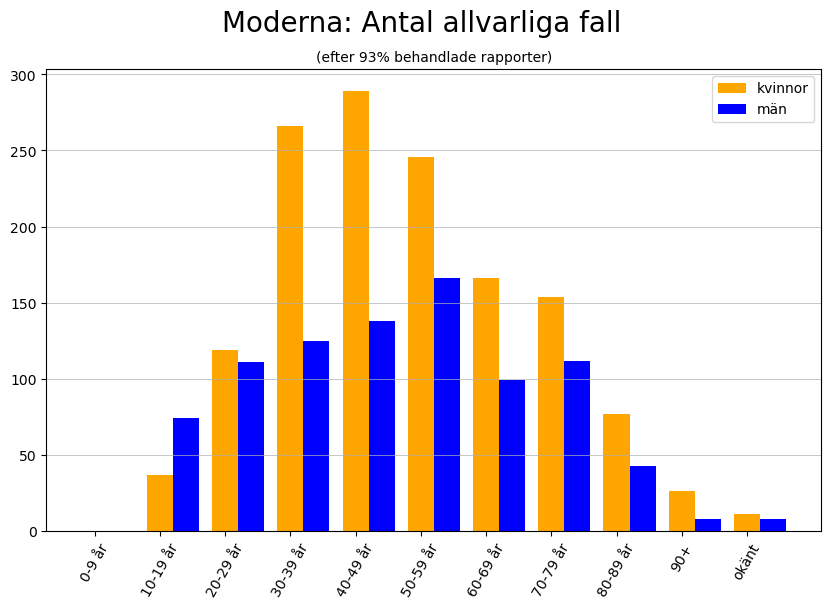

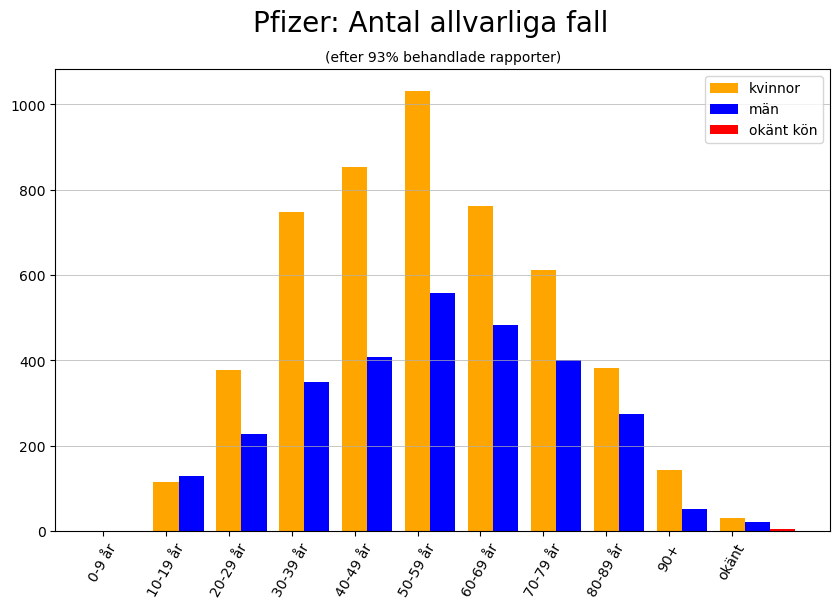

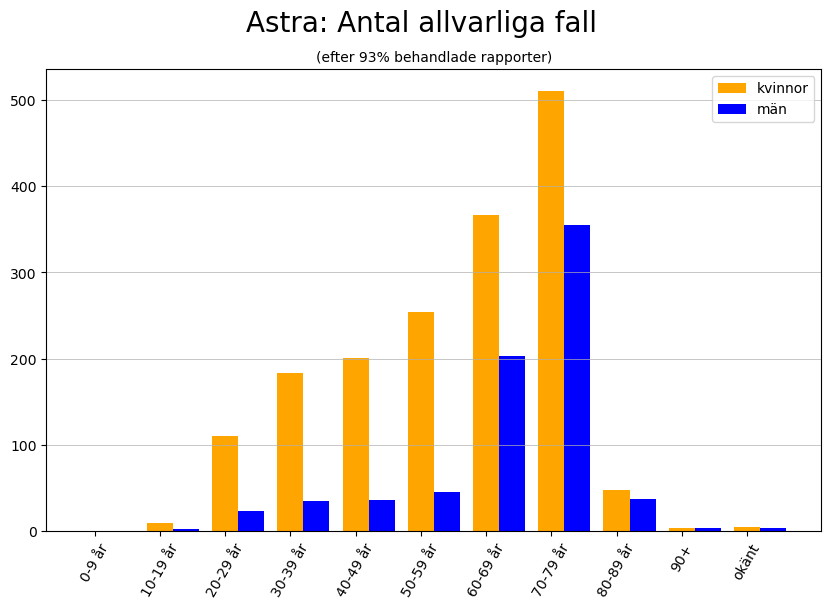

In [21]:
import matplotlib.pyplot as plt
import numpy as np
def plot_inkomna():
    plt.figure(figsize=(10,8))
    plt.plot(df_tot.index,df_tot['Pfizer'],label='Pfizer')
    plt.plot(df_tot.index,df_tot['Moderna'],label='Moderna')
    plt.plot(df_tot.index,df_tot['Astra'],label='Astra')
    plt.legend()
    plt.title('Antal rapporterade fall')
    plt.xlabel('Vecka')
    plt.ylabel('Antal rapporterade fall')
    plt.show()

def plot_allvarliga_per_ålder(åldrar, ftag):
    plt.figure(figsize=(10,6))
    spc = np.arange(len(ftag[åldrar]))
    plt.bar(spc, ftag['Allvarligt kvinnor'], width=0.4,label='kvinnor',color='orange')
    plt.bar(spc+0.4,ftag['Allvarligt män'], width=0.4,label='män',color='b')
    try:
        plt.bar(spc+0.8, ftag['Allvarligt okänd'],
                width=0.4, label='okänt kön', color='red')
    except:
        pass
    
    plt.xticks(spc,ftag[åldrar],rotation=60)
    plt.legend()
    andel_behandlade = int(round(df_tot.index.values[0]/summa_rapporter,2)*100)
    plt.title(f'(efter {andel_behandlade}% behandlade rapporter)',fontsize=10)
    plt.suptitle(f'{åldrar}: Antal allvarliga fall',fontsize=20)
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    nummer = 7 if åldrar == 'Totalt' else 8

    plt.savefig(f'{nummer} {åldrar}_allvarliga_per_åldersgrupp_{datum}_v{week}.jpg')
    plt.show()
plot_allvarliga_per_ålder('Moderna',moderna)
plot_allvarliga_per_ålder('Pfizer', pfizer)
plot_allvarliga_per_ålder('Astra',astra)


Allvarligt kvinnor
[  0  37 119 266 289 246 166 154  77  26  11]
[   1  115  377  747  854 1031  762  612  383  144   30]
[  0   9 110 183 201 254 366 510  48   3   5]
[   1  161  606 1196 1344 1531 1294 1276  508  173   46]
Allvarligt män
[  0  74 111 125 138 166  99 112  43   8   8]
[  0 130 228 349 409 557 482 402 274  51  22]
[  0   2  23  35  36  45 203 355  37   4   3]
[  0 206 362 509 583 768 784 869 354  63  33]
Allvarligt okänd
[0 0 0 0 0 0 0 0 0 0 4]
[0 0 0 0 0 0 0 0 0 0 4]
Ej allvarligt kvinnor
[   4  331 2156 3547 3626 3014 1295  600  181   25   13]
[   9  736 5279 7798 7418 7128 3871 1431  487  127   80]
[   1  128 2389 3173 3029 3300 3410 2363  100    2   39]
[   14  1195  9824 14518 14073 13442  8576  4394   768   154   132]
Ej allvarligt män
[   1  131  497 1076 1107  935  381  214   91   11    7]
[   6  363 1151 1879 1879 2067 1313  667  251   46   16]
[  2  17 428 563 363 297 964 994  47   2   7]
[   9  511 2076 3518 3349 3299 2658 1875  389   59   30]


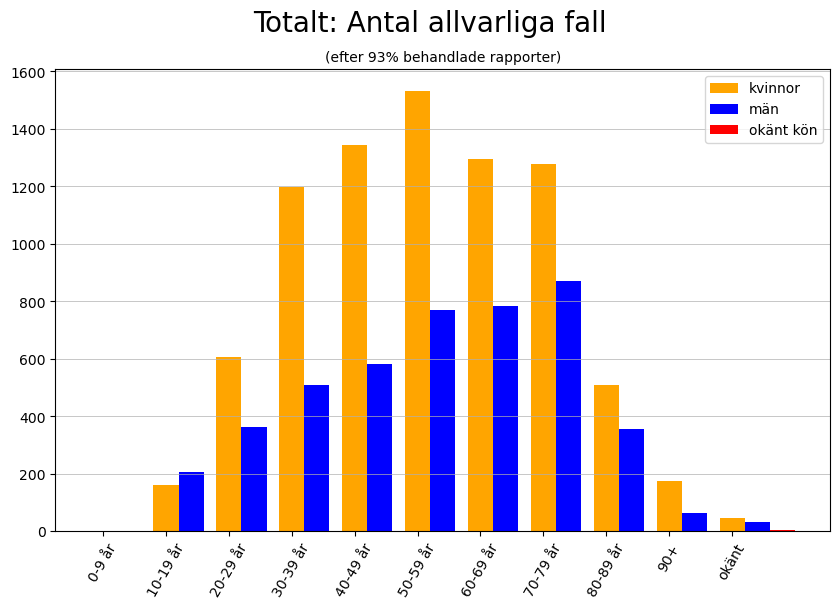

In [22]:
if pfizer.iloc[0,0] != '0-9 år':
    pf=pd.DataFrame([['0-9 år',0,0,0,0,0,0]],columns=pfizer.columns)
    pfizer = pd.concat([pf,pfizer])
    
if moderna.iloc[0,0] != '0-9 år':
    pf=pd.DataFrame([['0-9 år',0,0,0,0]],columns=moderna.columns)
    moderna = pd.concat([pf,moderna])
    
if astra.iloc[0,0] != '0-9 år':
    pf=pd.DataFrame([['0-9 år',0,0,0,0]],columns=astra.columns)
    astra = pd.concat([pf,astra])
       
df_tot_per_ålder = pd.DataFrame(columns=['Totalt','Allvarligt kvinnor','Allvarligt män','Allvarligt okänd','Ej allvarligt kvinnor','Ej allvarligt män'])
df_tot_per_ålder['Totalt'] = moderna.Moderna
for kol in df_tot_per_ålder.columns[1:]:
    print(kol)
    try:
        print(moderna[kol].values)
    except:
        moderna[kol] =  0
    
    try:     
        print(pfizer[kol].values)
    except:
        pfizer[kol] = 0
    
    try:    
        print(astra[kol].values)
    except:
        astra[kol] = 0
        
    df_tot_per_ålder[kol] = moderna[kol].values+pfizer[kol].values+astra[kol].values
    print(df_tot_per_ålder[kol].values)
    
df_tot_per_ålder

plot_allvarliga_per_ålder('Totalt',df_tot_per_ålder)

In [23]:
# astra.to_csv('astra_per_ålder.csv',index=False)
# pfizer.to_csv('pfizer_per_ålder.csv',index=False)
# moderna.to_csv('moderna_per_ålder.csv',index=False)
# df_tot_per_ålder.to_csv('totalt_allvarliga_per_ålder.csv',index=False)

# Kör allt ovan fram till hit
## Glöm inte att spara ner pdf-filerna först!
---

---
# Tester

In [ ]:
(8674+1774+5088)/(45353+17560+24467+359
                  )